In [ ]:
from transformers import YolosImageProcessor, YolosForObjectDetection
from PIL import Image
import torch
import requests

In [14]:
image = Image.open('data/blend.png')

In [15]:
model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

In [ ]:
inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

In [6]:
logits = outputs.logits
bboxes = outputs.pred_boxes

In [2]:
from dotenv import load_dotenv
from roboflow import Roboflow
import os
_ = load_dotenv()

In [3]:

from roboflow import Roboflow
rf = Roboflow(api_key=os.getenv("ROBOFLOW_API_KEY"))
project = rf.workspace("vex2").project("detect_rings")
version = project.version(5)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.58, to fix: `pip install ultralytics==8.0.196`
Exporting format yolov8 in progress : 85.0%
Version export complete for yolov8 format



Extracting Dataset Version Zip to detect_rings-5 in yolov8:: 100%|██████████| 196/196 [00:00<00:00, 10462.41it/s]


In [1]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.pt")

In [ ]:
model.train(data="detect_rings-5/data.yaml", epochs=100)

In [2]:
from ultralytics import YOLO

model = YOLO("best.pt") # YOLO will create a file with "best" and "last weights"

In [3]:
model.export(format="tflite") # Can be exported to use elsewhere. Don't need to worry about platform specifically

Ultralytics YOLOv8.2.58 🚀 Python-3.11.9 torch-2.3.1+cu121 CPU (AMD Ryzen 5 5600 6-Core Processor)
Model summary (fused): 168 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 6, 8400) (6.0 MB)

TensorFlow SavedModel: starting export with tensorflow 2.17.0...


100%|██████████| 1.11M/1.11M [00:00<00:00, 23.0MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /home/sgarg26/Documents/p5/yolo/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 47.33file/s]


ONNX: starting export with onnx 1.16.1 opset 17...


ONNX: slimming with onnxslim 0.1.32...
ONNX: export success ✅ 2.0s, saved as 'best.onnx' (11.8 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.22.3...


I0000 00:00:1721860875.878627   11648 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
W0000 00:00:1721860877.149297   11648 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721860877.149371   11648 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.
I0000 00:00:1721860877.679275   11648 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
W0000 00:00:1721860878.956881   11648 tf_tfl_flatbuffer_helpers.cc:392] Ignored output_format.
W0000 00:00:1721860878.956956   11648 tf_tfl_flatbuffer_helpers.cc:395] Ignored drop_control_dependency.


TensorFlow SavedModel: export success ✅ 18.2s, saved as 'best_saved_model' (29.5 MB)

TensorFlow Lite: starting export with tensorflow 2.17.0...
TensorFlow Lite: export success ✅ 0.0s, saved as 'best_saved_model/best_float32.tflite' (11.7 MB)

Export complete (20.0s)
Results saved to /home/sgarg26/Documents/p5/yolo
Predict:         yolo predict task=detect model=best_saved_model/best_float32.tflite imgsz=640  
Validate:        yolo val task=detect model=best_saved_model/best_float32.tflite imgsz=640 data=detect_rings-5/data.yaml  
Visualize:       https://netron.app


'best_saved_model/best_float32.tflite'

In [3]:
tflite = YOLO("best_float32.tflite")

results = tflite("vex.jpg")

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.
Loading best_float32.tflite for TensorFlow Lite inference...



INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


image 1/1 /home/sgarg26/Documents/p5/yolo/vex.jpg: 640x640 11 blues, 11 reds, 85.3ms
Speed: 6.0ms preprocess, 85.3ms inference, 12.4ms postprocess per image at shape (1, 3, 640, 640)


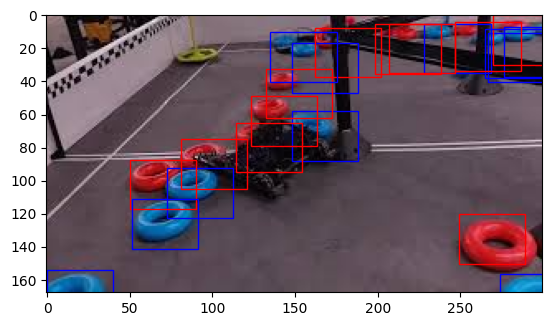

In [21]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

im = Image.open('vex.jpg')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)
boxes = results[0].boxes.data
classes = results[0].boxes.data[:, -1].int()

for i in range(len(boxes)):
    x1, y1, x2, y2 = boxes[i][:4]
    if classes[i] == 1: rect = patches.Rectangle((x1, y1, x2, y2), 40, 30, linewidth=1, edgecolor='r', facecolor='none')
    else: rect = patches.Rectangle((x1, y1, x2, y2), 40, 30, linewidth=1, edgecolor='b', facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)

plt.show()